In [69]:
import sys
import seaborn as sns
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import avalanches as crfn
import admin_functions as adfn
import plot as pltfn
import scipy
from scipy import stats 
import IS as isfn
import network as netfn

sns.reset_orig()
#plt.style.use('dark_background')
%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.8.3 (default, Jul  2 2020, 11:26:31) \n[Clang 10.0.0 ]'

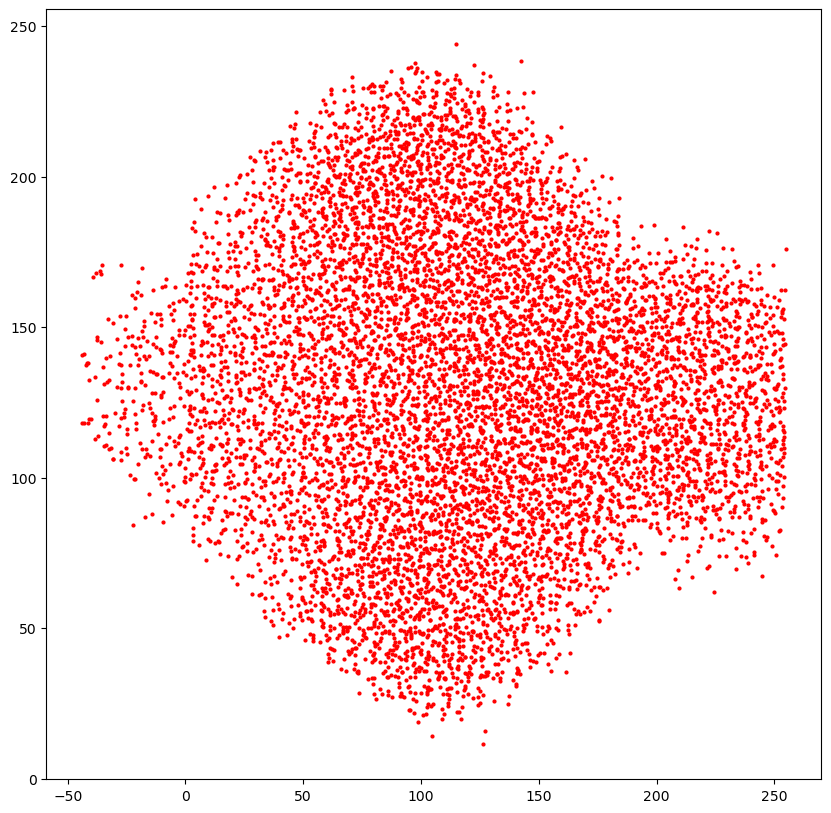

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
node = sorted(glob.glob('knodes*'))
fig,axarr = plt.subplots(figsize = (10,10))
nodes = np.load(node[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 4, color = 'red' , alpha = 1)
plt.show()

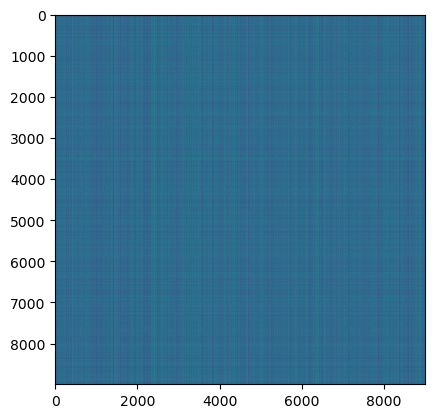

In [3]:
# K LIN + P LIN SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = np.array(np.append(0.001, np.linspace(0.1, 1, 11))).tolist()
k_vals = np.array(np.append(1/nodes.shape[0], [i/nodes.shape[0] for i in np.linspace(20, 200, 11)])).tolist()
cell_locs = nodes
dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()

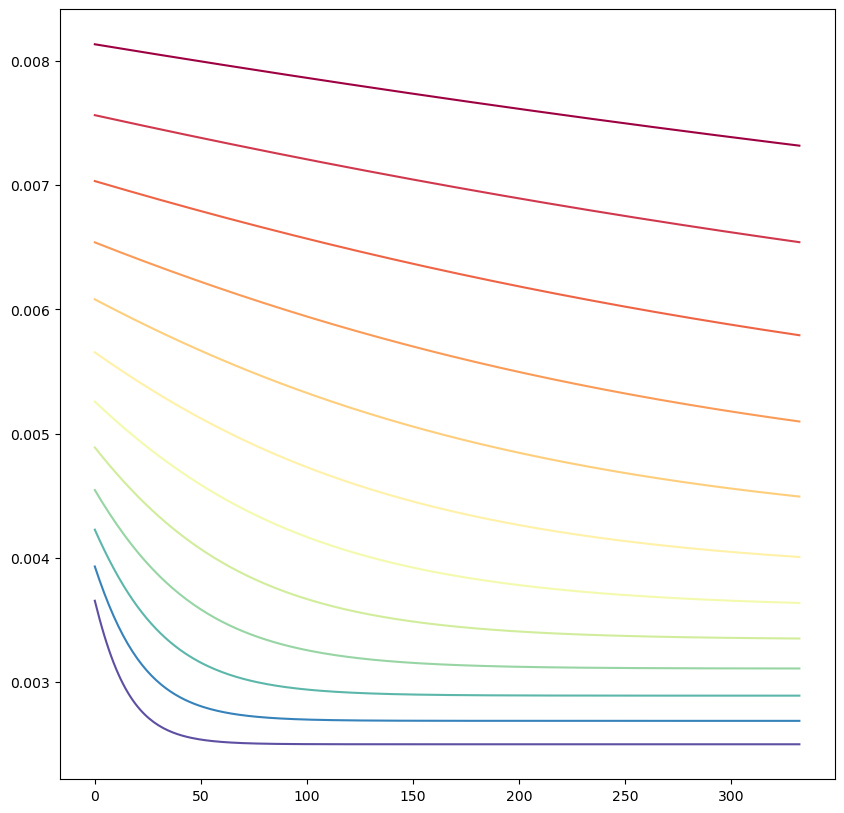

In [4]:
# Simple sigmoid function to 'soften' the exponential
#-------------------------------------------------------------------------------
def sig(x):
  return 1 / (1+np.exp(-x))

# Conversion from distance to edge weights, scaled (itself exponentially) by s
#-------------------------------------------------------------------------------
def dist2edge(distance, divisor, s):
  edgeweights = np.exp(s/5)*sig(np.exp(-soften/np.exp(s)*distance))/divisor
  return edgeweights

#S parameters
Nsteps  = 12
divisor = 200
soften = 0.07
s_vals   = np.array(np.linspace(0, 4, Nsteps)).tolist()

#Plot each s value
fig, ax = plt.subplots(1, figsize=(10,10))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))
distance = np.linspace(0, np.max(dist), 300)
for s in range(len(s_vals)):
  ax.plot(distance, dist2edge(distance, divisor, s_vals[s]), c=colors[s])
plt.show()


In [5]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))[:1]
p20list = sorted(glob.glob('*PTZ20*_av.npy*'))[:1]

In [6]:
choose = 0
bln_distlist = [np.load(blnlist[i])[choose] for i in range(len(blnlist))]
p20_distlist = [np.load(p20list[i])[choose] for i in range(len(p20list))]
bln_vec = []
p20_vec = []
for i in range(len(bln_distlist)):
    bln_vec = np.append(bln_vec, bln_distlist[i])
    p20_vec = np.append(p20_vec, p20_distlist[i])

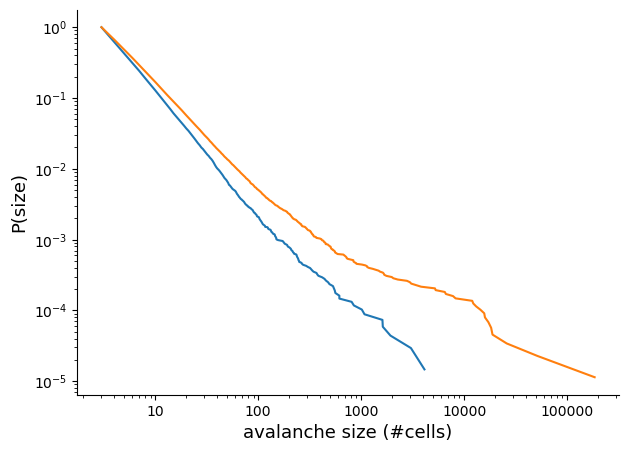

In [7]:
import matplotlib
import powerlaw
os.chdir(Fdrop + 'Project/' + experiment)
fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)


axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [8]:
#Calculate number of simulatons to do - to have 95% chance of generating maximum avalanche
def num_sims(empirical, cutoff):
    import matplotlib.pyplot as plt
    import math
    fig, axarr = plt.subplots(figsize = (7,5))
    hist = axarr.hist(empirical, bins = 100000, density = True, histtype = 'step', cumulative = -1)
    p = 1-(10**(np.log10(hist[0])[np.where(np.log10(hist[1]) > np.log10(cutoff))[0][0]])) #probability of getting avalanches of size cutoff or smaller
    number = 0.05 
    base = p
    exponent = int(math.log(number, base)) #number of simulations as the power to which p is raised to get 95% probability 
    return(exponent)

#Simulation parameters
#======================
cutoff = 1000
n_sims= num_sims(bln_vec, cutoff)
n_sims

29156

In [66]:
import random
s0 = random.uniform(0, 5)
k0 = random.randint(10, 40)

print('divisor = ' + str(divisor))
print('soften = ' + str(soften))
print('cutoff = ' + str(cutoff))
print('n_sims = ' + str(n_sims))
print('s0 = ' + str(s0))
print('k0 = ' + str(k0))

divisor = 200
soften = 0.07
cutoff = 1000
n_sims = 29156
s0 = 2.4252375927675116
k0 = 25


In [ ]:
#Parameter sweep
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import stats
total_list = []
def ks_dist(params):
    print(params)  # <-- you'll see that params is a NumPy array
    s, k  = params # <-- for readability you may wish to assign names to the component variables
    avs = netfn.ba_netsim(dist).simulate(s, int(k), 0.6,  divisor, soften, cutoff, n_sims, 1).av_size
    ks = stats.ks_2samp(empirical, avs)[0]
    total_list.append([params, ks, avs])
    print('ks = ' + str(ks))
    return ks

#Define params
empirical = p20_vec
dist = dist
ranges = (slice(0, 5, 0.1), slice(10, 35, 1))
result = brute(ks_dist, ranges)

In [82]:
result

array([-1.24972209e-04,  1.04994608e+01])

In [92]:
os.chdir(Fdrop + 'Project/' + experiment)

costlist, paramlist, avlist = list(range(len(total_list))), list(range(len(total_list))), list(range(len(total_list)))
for i in range(len(total_list)):
    paramlist[i] = total_list[i][0]
    costlist[i] = total_list[i][1]
    avlist[i] = total_list[i][2]
    
np.save('optimise_brute_ksdistlow_ba_p20f1_params.npy',   paramlist)
np.save('optimise_brute_ksdistlow_ba_p20f1_cost.npy',    costlist)
np.save('optimise_brute_ksdistlow_ba_p20f1_avs.npy',  avlist)

print('iterations = ' + str(len(costlist)) + '  true min = ' + str(np.where(costlist == np.min(costlist))[0][0]))
print('min cost = ' + str(costlist[np.where(costlist == np.min(costlist))[0][0]]))
print('min params = ' + str(paramlist[np.where(costlist == np.min(costlist))[0][0]]))
curr = avlist[np.where(costlist == np.min(costlist))[0][0]]

iterations = 1652  true min = 1637
min cost = 0.010649461443859864
min params = [ 2.91109167 18.81563224]


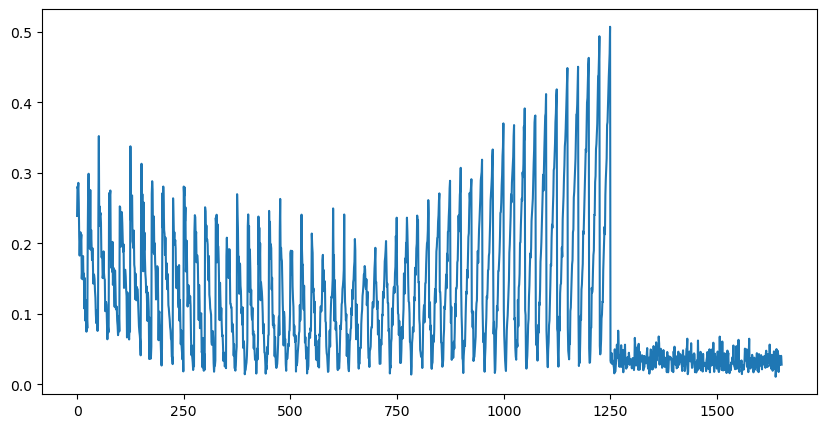

In [93]:
fig = plt.figure(figsize= (10,5))
plt.plot(np.arange(0, len(costlist)), costlist)
plt.show()

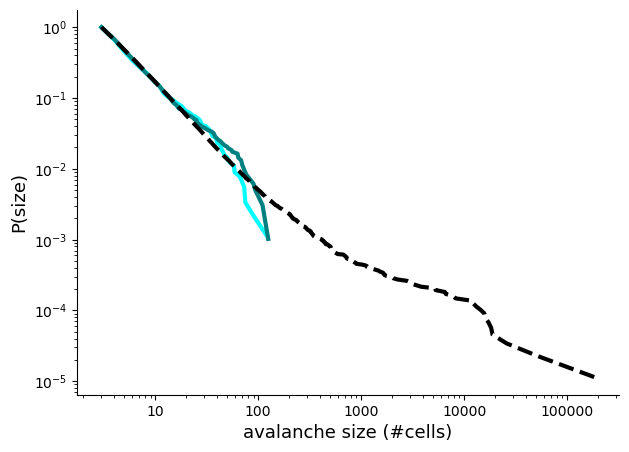

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   

avdistcut = avlist[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = avlist[np.where(costlist == np.min(costlist))[0][0]]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'teal')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

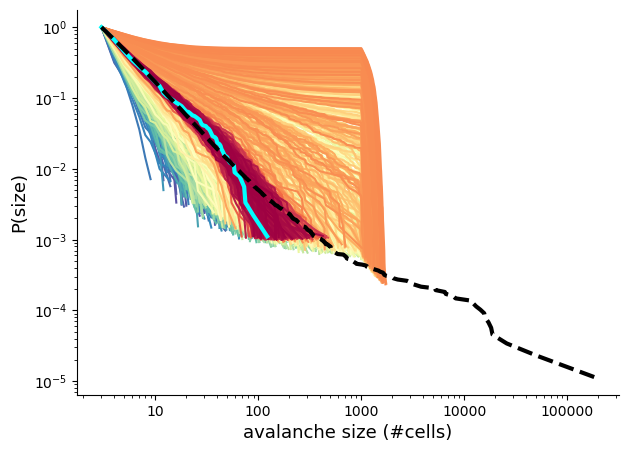

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

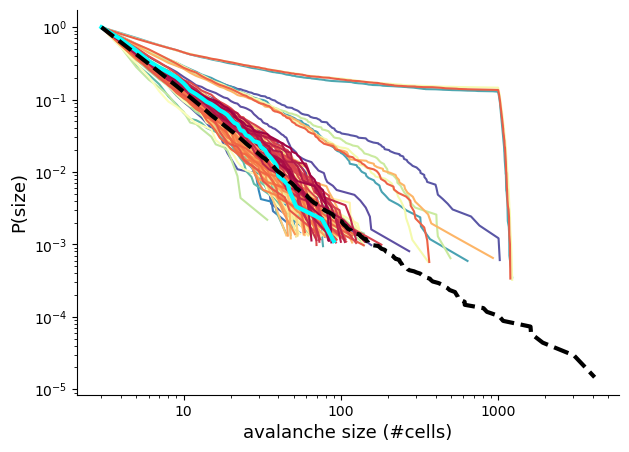

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')
#avdistcut = tofit_d
#powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [73]:
costlist, paramlist, avlist = list(range(len(total_list))), list(range(len(total_list))), list(range(len(total_list)))
for i in range(len(total_list)):
    paramlist[i] = total_list[i][0]
    costlist[i] = total_list[i][1]
    avlist[i] = total_list[i][2]

print('iterations = ' + str(len(costlist)) + ',  search minima = ' + str(np.where(costlist == np.min(costlist))[0][0]))
print('min cost = ' + str(costlist[np.where(costlist == np.min(costlist))[0][0]]))
print('min params = ' + str(paramlist[np.where(costlist == np.min(costlist))[0][0]]))
curr = avlist[np.where(costlist == np.min(costlist))[0][0]]

iterations = 137,  search minima = 50
min cost = 0.009041971746721278
min params = [ 1.41063699 24.10298601]


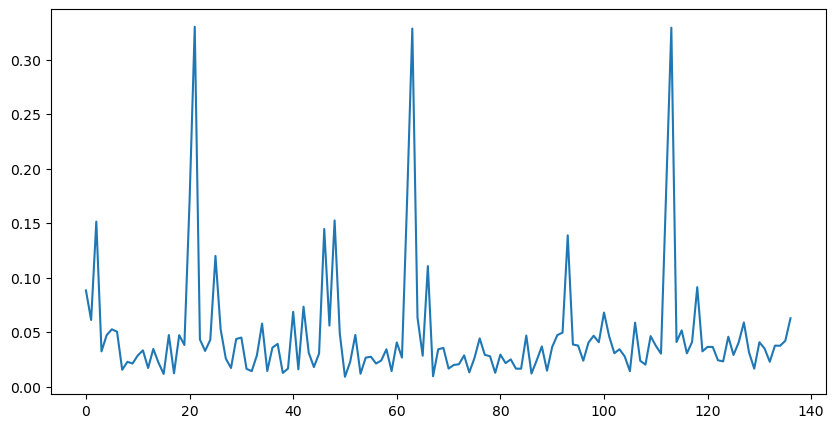

In [74]:
fig = plt.figure(figsize= (10,5))
plt.plot(np.arange(0, len(costlist)), costlist)
plt.show()

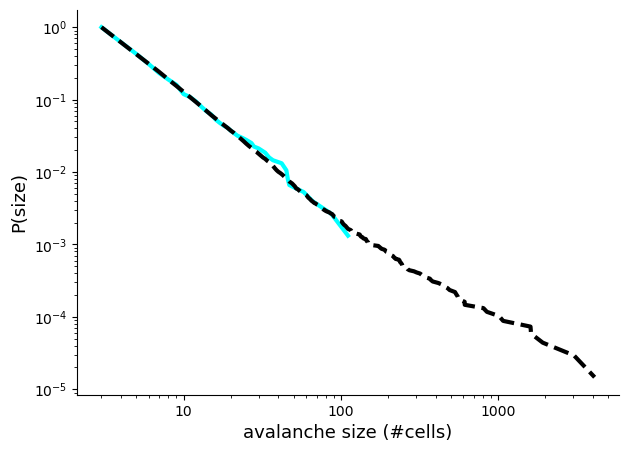

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   

avdistcut = curr
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [ ]:
def solution(s):
    # This function takes a string sequence as input and returns 
    # the maximum number of identical sequences that the string 
    # can be divided into without leaving any string leftovers
    
    # Input: s = non-empty string 
    # Output: an integer value representing the number of sequences
    t_len = len(s) #length of string
    
    #Find divisors of string
    for i in list(range(t_len)): #loop through all possible divisors
        if t_len % (i+1) == 0 : #check if fully divisible by i
            div = i+1 #div is current divisor

            #Split into equal parts
            seq_list = [s[i:i+div] for i in range(0, len(s), div)] #list of segments of length div

            #if segments are equal then return
            if all(x==seq_list[0] for x in seq_list) == True: #do all segments have the same sequence?
                return(int(t_len/div)) #return number of segments 

    #If we no divisors create equal parts    
    #print('We cant split the cake with equal MandMs, im sorry minions!')
    


In [54]:
def solution(s):
    
    #Find indeces of employees
    def find_index(string, symbol):
        return [i for i, current in enumerate(string) if current == symbol]
    
    left = find_index(s,'<')
    right = find_index(s,'>')

    salutes = 0
    for i in range(len(left)): #loop through all left walkers
        for e in range(len(right)): #loop through all right walkers
            if left[i] > right[e]: #if left walker is going to cross with right
                salutes+=2
    return(salutes)
    

In [ ]:
def solution(total_lambs): 
    
    #Function that calculates the next henchman LAMBs if being stingy
    def stingy(hench_list):
        return(sum(hench_list[len(hench_list)-2:])) #Next henchman must have LAMBS = two henchmen below

    #Function that calculates the next henchman LAMBs if being generous
    def generous(hench_list):
        return(2*(hench_list[len(hench_list)-1])) #Next henchman must have 2x that of 1 henchman below

    #for loop inputs
    func_list = [stingy, generous] #iterate through each function
    compare_list = list(xrange(2)) #empty list

    #Loop through functions
    for e in xrange(len(func_list)):
        hench_list = [1] #initialise list - first henchman always has 1 LAMB
        #Loop through possible LAMBs
        for i in xrange(total_lambs):
            new_value = func_list[e](hench_list) #calculate LAMBS for next henchman
            
            #If there are enough LAMBS to add next henchman
            if total_lambs - (sum(hench_list) + new_value) >=0:
                hench_list.append(new_value) #add new LAMB value
            
            #If no LAMBS leftover then add to list
            else:
                compare_list[e] = len(hench_list)
                break
    
    #Calculate difference between stingy list length and generous list length
    return(compare_list[0] - compare_list[1])
